In [153]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.spatial.transform import Rotation
import heapq
import pandas as pd
from itertools import count

from PointCloudDataFrame import PointCloudDataFrame

def center(df: pd.DataFrame):
    df2 = df.copy()
    df2[['x', 'y', 'z']] -= df2[['x', 'y', 'z']].mean(axis=0)
    return df2

def rotate_xy(df: pd.DataFrame, theta: float):
    x = np.cos(theta)*self['x'] - np.sin(theta)*self['y']
    y = np.sin(theta)*self['x'] + np.cos(theta)*self['y']
    df2 = df.copy()
    df2[['x', 'y']] = [x, y]
    return df

df = PointCloudDataFrame.read_label('label/original-cropped.txt')

model = df.loc[df['label'] != '', ['x', 'y', 'z', 'label']].groupby(['label']).mean()
model.to_csv('model/model1.csv')

In [154]:
fix = pd.read_csv('model/model1.csv', index_col='label').to_numpy()

In [155]:
theta = np.random.rand(3)
print(theta)
offset = np.random.rand(3)
print(offset)

mov = Rotation.from_rotvec(theta).apply(fix)
# mov = fix.copy()
mov += offset
mov += (np.random.rand(*mov.shape)-0.5)/250

[0.21444956 0.86323628 0.7717581 ]
[0.46256604 0.90424817 0.99227121]


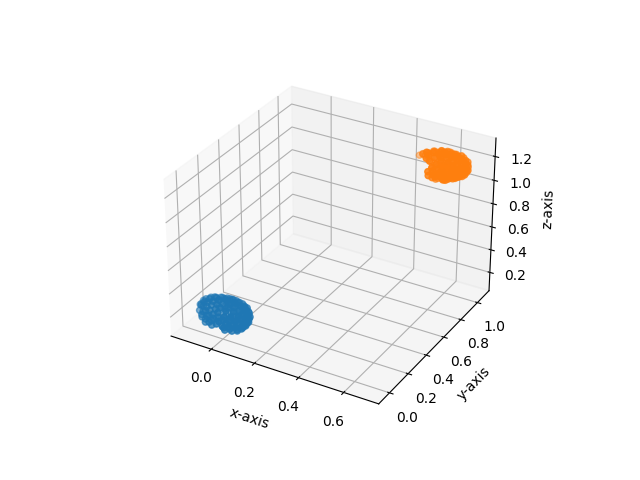

In [156]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(fix[:,0], fix[:,1], fix[:,2])
ax.scatter(mov[:,0], mov[:,1], mov[:,2])

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
plt.show()

In [157]:
def tivs(array: np.ndarray):
    l = list()
    for i1, row1 in enumerate(array):
        for i2, row2 in enumerate(array):
            if i1 != i2:
                l.append(row1-row2)
    return np.array(l)

In [158]:
def select_ordered(array: np.ndarray, n, start=0):
    norm = np.linalg.norm(array, axis=1)
    a = np.concatenate((array, norm.reshape(-1,1)), axis=1)
    a = a[a[:,3].argsort()][::-1]
    return a[start:start+n,:3]

In [159]:
M = select_ordered(tivs(mov), 200, int(mov.shape[0]/50))
S = select_ordered(tivs(fix), 200, int(mov.shape[0]/50))

In [160]:
class Cube:
    def __init__(self, min, max):
        self.min = np.array(min)
        self.max = np.array(max)
        self.mid = (self.min+self.max)/2
        
    def subdivide(self):
        return [
            Cube(self.min, self.mid),
            Cube([self.min[0], self.min[1], self.mid[2]], [self.mid[0], self.mid[1], self.max[2]]),
            Cube([self.min[0], self.mid[1], self.min[2]], [self.mid[0], self.max[1], self.mid[2]]),
            Cube([self.min[0], self.mid[1], self.mid[2]], [self.mid[0], self.max[1], self.max[2]]),
            Cube([self.mid[0], self.min[1], self.min[2]], [self.max[0], self.mid[1], self.mid[2]]),
            Cube([self.mid[0], self.min[1], self.mid[2]], [self.max[0], self.mid[1], self.max[2]]),
            Cube([self.mid[0], self.mid[1], self.min[2]], [self.max[0], self.max[1], self.mid[2]]),
            Cube(self.mid, self.max),
        ]

class IntegralVolume:
    def __init__(self, points, n, delta=0.001) -> None:
        self.n = n
        self.domain = Cube(np.min(points, axis=0)-delta, np.max(points, axis=0)+delta)
        self.delta = (self.domain.max-self.domain.min)/n
        self.areas = np.zeros((n+1,) * 3, dtype=int)
        for p in points:
            slices = tuple(slice(-i, None) for i in self.indices(p))
            self.areas[slices] += 1

    def indices(self, point):
        pos = np.clip((np.array(point) - self.domain.min)/self.delta, 0, self.n)
        return tuple(np.ceil(pos).astype(int))
    
    def area(self, cube: Cube):
        A = self.indices(cube.min)
        B = self.indices([cube.min[0], cube.min[1], cube.max[2]])
        C = self.indices([cube.min[0], cube.max[1], cube.min[2]])
        D = self.indices([cube.min[0], cube.max[1], cube.max[2]])
        E = self.indices([cube.max[0], cube.min[1], cube.max[2]])
        F = self.indices([cube.max[0], cube.min[1], cube.max[2]])
        G = self.indices([cube.max[0], cube.max[1], cube.min[2]])
        H = self.indices(cube.max)

        return self.areas[H] - self.areas[G] - self.areas[F] + self.areas[E] \
             - self.areas[D] + self.areas[C] - self.areas[B] + self.areas[A]

In [161]:
def q_func(moving, fixed, eps):
    return sum(1 - np.clip(np.min(cdist(moving, fixed), axis=1)/eps, 0, 1)**10)

In [162]:
def q_upper_func(moving, fixed, eps, cube: Cube):
    alpha = np.linalg.norm(cube.max - cube.min)/2
    delta = np.sqrt(2 * np.linalg.norm(moving, axis=1)**2 * (1 - np.cos(alpha)))
    return sum(1 - np.clip((np.min(cdist(moving, fixed), axis=1) - delta)/eps, 0, 1)**10)

In [163]:
def rotation_search(M: np.ndarray, S: np.ndarray):
    eps = 0.01
    q_max = 0
    c = Cube([-np.pi, -np.pi, -np.pi], [np.pi, np.pi, np.pi])
    r_opt = Rotation.from_rotvec(c.mid)
    gap = M.shape[0] * 0.25

    counter = count()
    queue = [(-q_upper_func(M, S, eps, c), next(counter), c)]
    
    while len(queue):
        q_upper, _, c = heapq.heappop(queue)
        q_upper *= -1

        if q_upper - q_max < gap:
            break

        r_c = Rotation.from_rotvec(c.mid)
        q_actual = q_func(r_c.apply(M), S, eps)
        if q_actual > q_max:
            q_max = q_actual
            r_opt = r_c
            # print(r_opt.as_rotvec(), q_max)

        for sub_c in c.subdivide():
            r_c = Rotation.from_rotvec(sub_c.mid)
            q_upper = q_upper_func(r_c.apply(M), S, eps, sub_c)
            if q_upper > q_max:
                heapq.heappush(queue, (-q_upper, next(counter), sub_c))
    
    return r_opt, q_max

In [164]:
r_opt, q_max = rotation_search(M, S)
print(r_opt.as_rotvec(), q_max)

[-0.22089323 -0.85902924 -0.76085447] 187.64304137444105


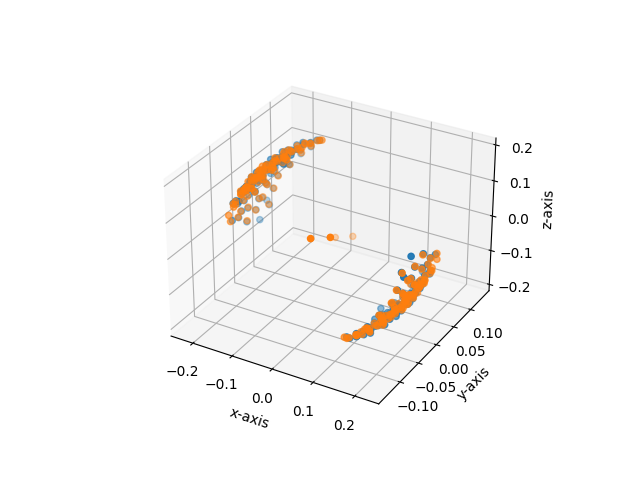

In [165]:
M2 = r_opt.apply(M)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(S[:,0], S[:,1], S[:,2])
ax.scatter(M2[:,0], M2[:,1], M2[:,2])

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
plt.show()

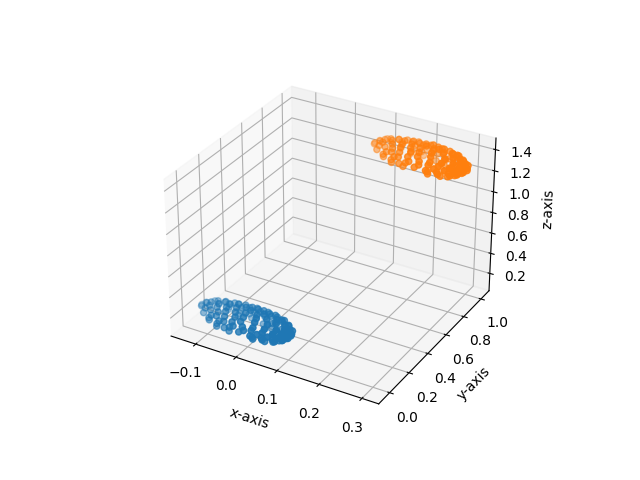

In [166]:
mov2 = r_opt.apply(mov)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(fix[:,0], fix[:,1], fix[:,2])
ax.scatter(mov2[:,0], mov2[:,1], mov2[:,2])

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
plt.show()

In [167]:
def translation_search(M: np.ndarray, S: np.ndarray):
    eps = 0.0025
    q_max = 0
    c = Cube(np.min(S, axis=0) - np.max(M, axis=0), np.max(S, axis=0) - np.min(M, axis=0))
    t_opt = c.mid
    gap = M.shape[0] * 0.25

    counter = count()
    queue = [(-q_upper_func(M, S, eps, c), next(counter), c)]
    
    while len(queue):
        q_upper, _, c = heapq.heappop(queue)
        q_upper *= -1

        if q_upper - q_max < gap:
            break

        t_c = c.mid
        q_actual = q_func(M + t_c, S, eps)
        if q_actual > q_max:
            q_max = q_actual
            t_opt = t_c

        for sub_c in c.subdivide():
            t_c = sub_c.mid
            q_upper = q_upper_func(M + t_c, S, eps, sub_c)
            if q_upper > q_max:
                heapq.heappush(queue, (-q_upper, next(counter), sub_c))
    
    return t_opt, q_max

In [168]:
t_opt, q_max = translation_search(r_opt.apply(mov), fix)
print(t_opt, q_max)

[-0.21413355 -0.8755733  -1.09779207] 0


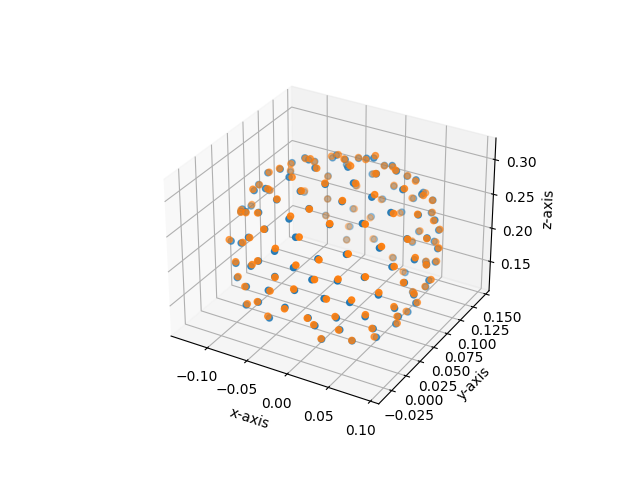

In [169]:
mov3 = r_opt.apply(mov) + t_opt

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(fix[:,0], fix[:,1], fix[:,2])
ax.scatter(mov3[:,0], mov3[:,1], mov3[:,2])

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
plt.show()